In [2]:
import numpy as np
import pandas as pd

In [4]:
data=pd.read_csv("test.csv")
data

date      open      high       low     close  volume
0       2015-01-09 09:15:00   8300.60   8309.75   8300.60   8308.35       0
1       2015-01-09 09:16:00   8308.35   8308.65   8304.05   8304.20       0
2       2015-01-09 09:17:00   8304.20   8308.20   8304.00   8308.20       0
3       2015-01-09 09:18:00   8308.20   8315.30   8308.20   8315.30       0
4       2015-01-09 09:19:00   8315.30   8316.10   8314.85   8316.10       0
...                     ...       ...       ...       ...       ...     ...
908892  2024-11-08 15:25:00  24986.20  24986.60  24974.80  24976.30       0
908893  2024-11-08 15:26:00  24976.50  24977.15  24965.25  24965.75       0
908894  2024-11-08 15:27:00  24966.20  24970.85  24960.85  24965.25       0
908895  2024-11-08 15:28:00  24965.50  24966.00  24954.70  24958.80       0
908896  2024-11-08 15:29:00  24959.75  24964.95  24954.10  24959.65       0

[908897 rows x 6 columns]

In [ ]:
moveing average stratergy

Initial Balance: ₹10000
Final Balance: ₹15279.83
Total Profit/Loss: ₹5279.83
Number of Trades Executed: 10
Total Profit/Loss from all trades: ₹5279.83

Trade Log:
    Sr. No.          Trade Time           Action    Price  Profit/Loss
0         1 2015-01-09 09:59:00         Buy Call  8296.05     0.000000
1         1 2015-01-09 10:10:00        Sell Call  8292.60  -363.081939
2         1 2015-01-09 10:10:00          Buy Put  8292.60     0.000000
3         2 2015-01-09 10:18:00         Buy Call  8295.60     0.000000
4         2 2015-01-09 10:35:00        Sell Call  8301.55   576.909642
5         2 2015-01-09 10:35:00          Buy Put  8301.55     0.000000
6         3 2015-01-09 10:54:00         Buy Call  8296.10     0.000000
7         3 2015-01-09 11:07:00        Sell Call  8294.15  -213.083548
8         3 2015-01-09 11:07:00          Buy Put  8294.15     0.000000
9         4 2015-01-09 11:44:00         Buy Call  8264.95     0.000000
10        4 2015-01-09 11:53:00        Sell Call  8265.9

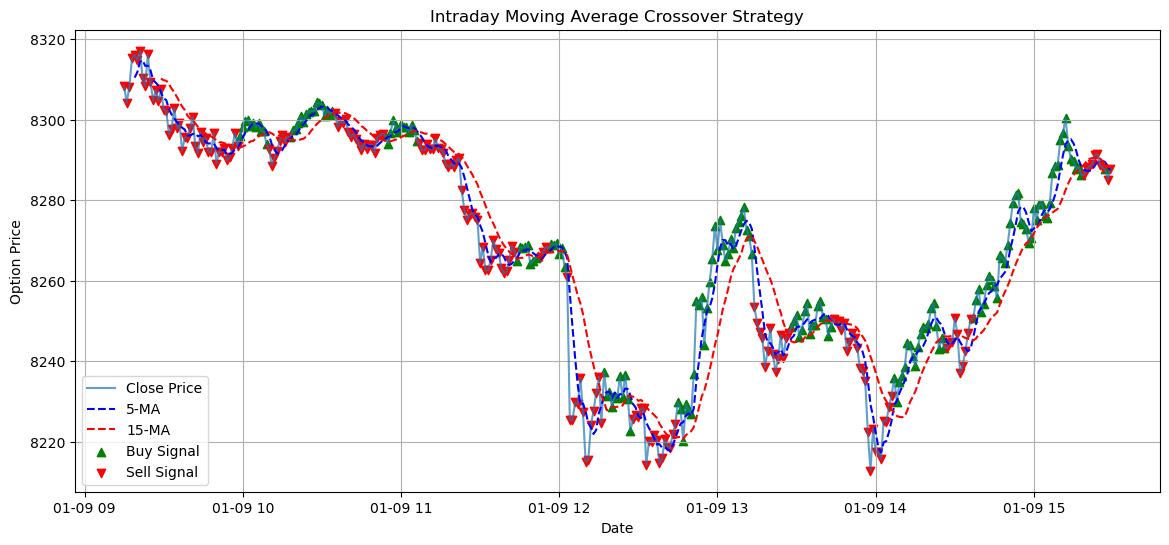

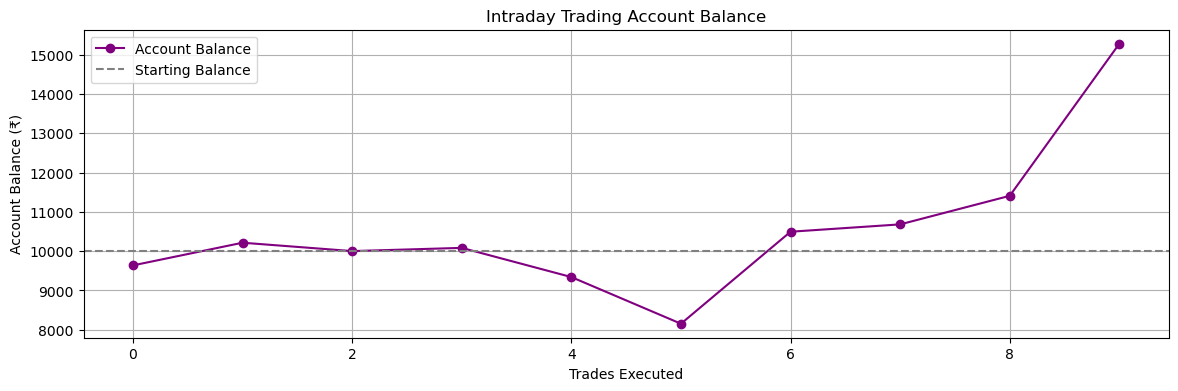

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Calculate Moving Averages (Short-term & Long-term)
df["5_MA"] = df["close"].rolling(window=5).mean()
df["15_MA"] = df["close"].rolling(window=15).mean()

# Generate Buy (Call) and Sell (Put) Signals
df["Signal"] = np.where(df["5_MA"] > df["15_MA"], 1, -1)  # 1 = Buy Call, -1 = Buy Put

# Set Market Open and Close Times
market_open = "09:15:00"
market_close = "15:15:00"

# Track positions, profit/loss
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
balance_over_time = []

position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

# Track the number of trades
num_trades = 0
total_profit_loss = 0

# Iterate through data to execute intraday strategy
for i in range(1, len(df)):
    curr_time = df["date"].iloc[i].time().strftime("%H:%M:%S")
    prev_signal = df["Signal"].iloc[i - 1]
    curr_signal = df["Signal"].iloc[i]
    close_price = df["close"].iloc[i]

    # Check if market is open
    if market_open <= curr_time <= market_close:
        # Entry Conditions
        if prev_signal != curr_signal:
            if curr_signal == 1:  # Buy Call
                position = "Call"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Call", "Price": close_price})

            elif curr_signal == -1 and position == "Call":  # Sell Call, Buy Put
                profit = (close_price - entry_price) * 100  # Assuming 1 contract (100 shares)

                # Calculate Transaction Costs (Brokerage, GST, STT)
                brokerage = entry_price * brokerage_rate
                gst = brokerage * gst_rate
                stt = close_price * stt_rate
                
                # Total transaction cost
                total_cost = brokerage + gst + stt
                
                # Final Profit or Loss after deducting charges
                final_profit_loss = profit - total_cost
                balance += final_profit_loss
                total_profit_loss += final_profit_loss

                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Sell Call", "Price": close_price, 
                                  "Profit/Loss": final_profit_loss})
                balance_over_time.append(balance)
                position = "Put"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Put", "Price": close_price})

                num_trades += 1  # Increase trade count

            elif curr_signal == 1 and position == "Put":  # Sell Put, Buy Call
                profit = (entry_price - close_price) * 100
                
                # Calculate Transaction Costs (Brokerage, GST, STT)
                brokerage = entry_price * brokerage_rate
                gst = brokerage * gst_rate
                stt = close_price * stt_rate
                
                # Total transaction cost
                total_cost = brokerage + gst + stt
                
                # Final Profit or Loss after deducting charges
                final_profit_loss = profit - total_cost
                balance += final_profit_loss
                total_profit_loss += final_profit_loss

                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Sell Put", "Price": close_price, 
                                  "Profit/Loss": final_profit_loss})
                balance_over_time.append(balance)
                position = "Call"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Call", "Price": close_price})

                num_trades += 1  # Increase trade count

    # Square-off (Exit before market close)
    if curr_time == market_close and position:
        if position == "Call":
            profit = (close_price - entry_price) * 100
        else:  # If position is "Put"
            profit = (entry_price - close_price) * 100

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = close_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss
        total_profit_loss += final_profit_loss

        trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": f"Square-off {position}", "Price": close_price, 
                          "Profit/Loss": final_profit_loss})
        balance_over_time.append(balance)
        position = None  # Reset position

        num_trades += 1  # Increase trade count

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Total Profit/Loss from all trades: ₹{total_profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price & Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["close"], label="Close Price", alpha=0.7)
plt.plot(df["date"], df["5_MA"], label="5-MA", linestyle="--", color="blue")
plt.plot(df["date"], df["15_MA"], label="15-MA", linestyle="--", color="red")

# Highlight Buy/Sell Signals
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]
plt.scatter(buy_signals["date"], buy_signals["close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals["date"], sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Intraday Moving Average Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Option Price")
plt.grid(True)
plt.show()

# Plot Profit/Loss Over Time
plt.figure(figsize=(14, 4))
plt.plot(balance_over_time, label="Account Balance", color="purple", linestyle="-", marker="o")
plt.axhline(y=initial_balance, color="gray", linestyle="--", label="Starting Balance")
plt.legend()
plt.title("Intraday Trading Account Balance")
plt.xlabel("Trades Executed")
plt.ylabel("Account Balance (₹)")
plt.grid(True)
plt.show()

In [ ]:
vwap

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00
Number of Trades Executed: 0
Total Profit/Loss from all trades: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


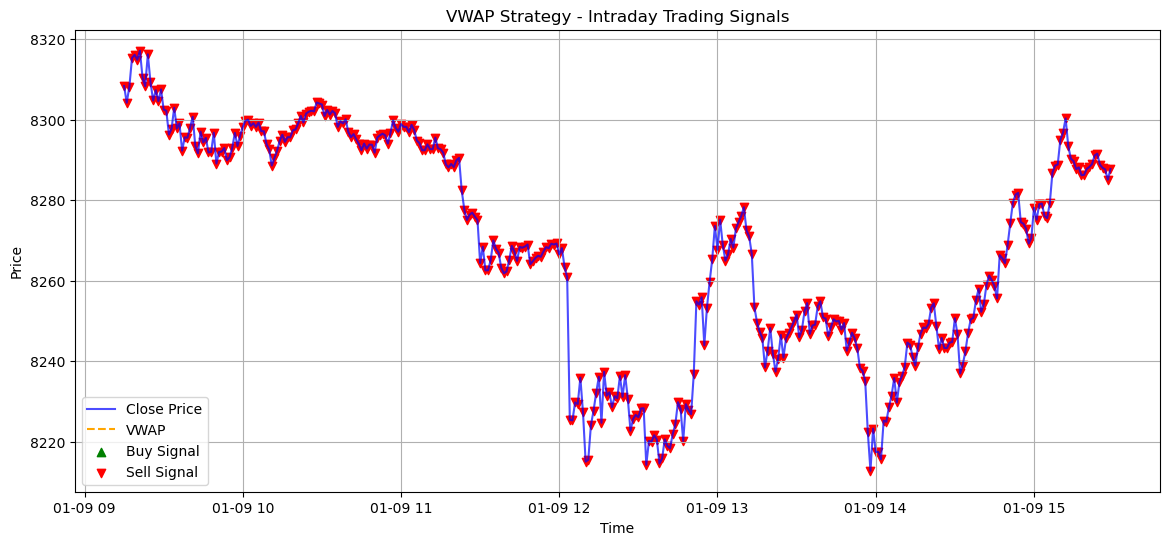

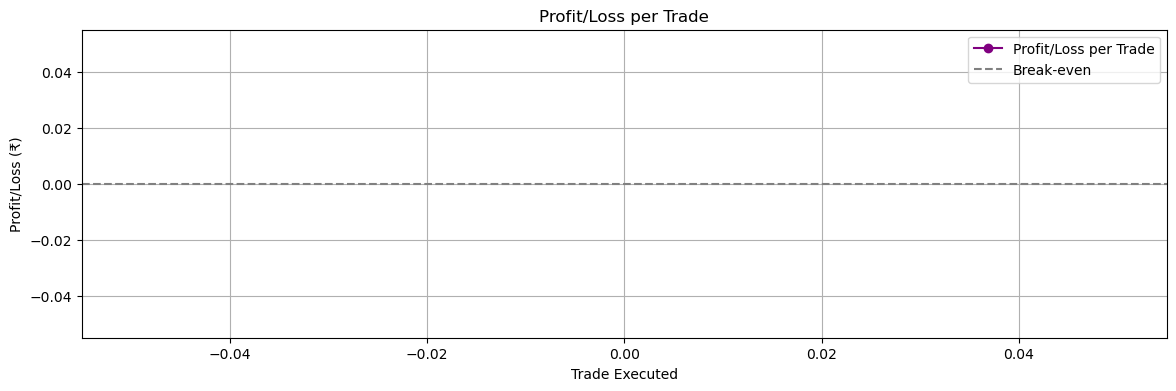

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by time
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# Calculate VWAP
df['Cumulative_Volume'] = df['volume'].cumsum()
df['Cumulative_Price_Volume'] = (df['close'] * df['volume']).cumsum()

# VWAP = Cumulative Price-Volume / Cumulative Volume
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

# Generate Buy and Sell Signals based on VWAP
df['Signal'] = np.where(df['close'] > df['VWAP'], 1, -1)  # 1 = Buy, -1 = Sell

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

# Track the number of trades
num_trades = 0
total_profit_loss = 0

for i in range(1, len(df)):
    # Buy Signal
    if df['Signal'].iloc[i] == 1 and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Sr. No.': num_trades + 1, 'Trade Time': df.index[i], 'Action': 'Buy', 'Price': entry_price})

    # Sell Signal
    elif df['Signal'].iloc[i] == -1 and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Sr. No.': num_trades + 1,
            'Trade Time': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit/Loss': final_profit_loss
        })
        
        position = None  # Reset position after the trade

        num_trades += 1  # Increase trade count

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Total Profit/Loss from all trades: ₹{total_profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and VWAP
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['VWAP'], label='VWAP', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('VWAP Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit/Loss'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Supertrend Strategy

Initial Balance: ₹10000
Final Balance: ₹9949.49
Total Profit/Loss: ₹-50.51

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 12:52:00    Buy  8254.90   0.000000
1 2015-01-09 13:57:00   Sell  8222.35 -50.513132


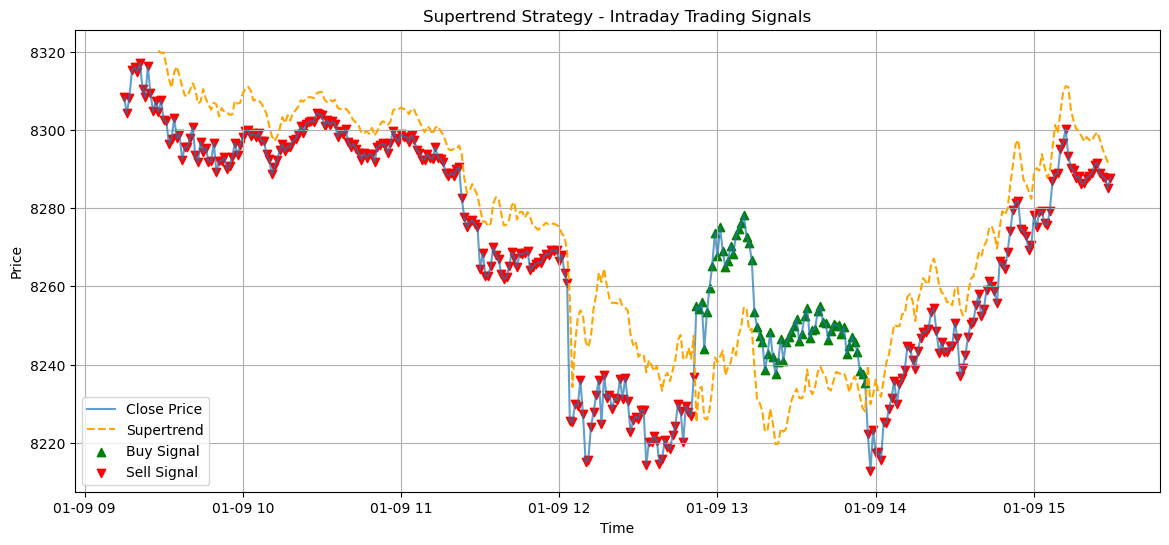

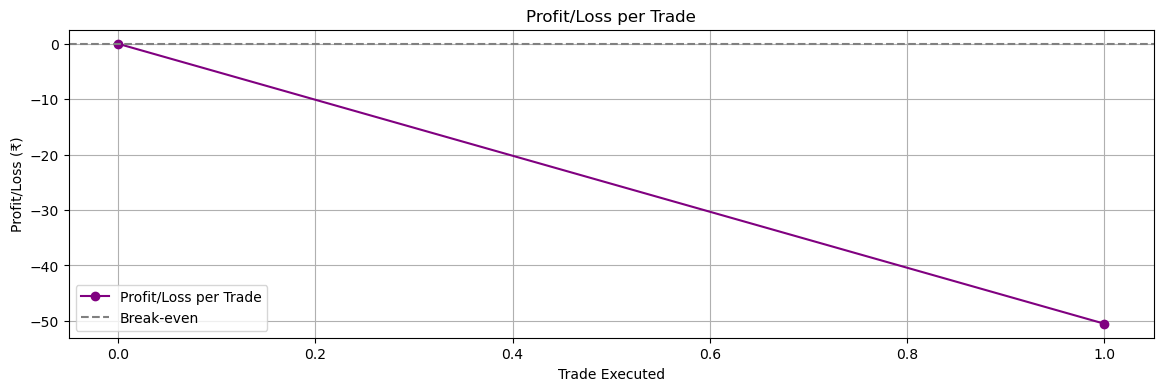

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by time
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# Calculate ATR (Average True Range)
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()  # Using 14-period ATR

# Supertrend calculation
multiplier = 3  # Multiplier for the Supertrend
df['Basic_Upper_Band'] = (df['high'] + df['low']) / 2 + multiplier * df['ATR']
df['Basic_Lower_Band'] = (df['high'] + df['low']) / 2 - multiplier * df['ATR']

# Initialize Supertrend column
df['Supertrend'] = np.nan

# Calculate Supertrend using .loc for safe assignment
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['Supertrend'].iloc[i-1]:
        df.loc[df.index[i], 'Supertrend'] = df['Basic_Lower_Band'].iloc[i]
    else:
        df.loc[df.index[i], 'Supertrend'] = df['Basic_Upper_Band'].iloc[i]

# Generate Buy and Sell signals
df['Signal'] = np.where(df['close'] > df['Supertrend'], 1, -1)  # 1 = Buy, -1 = Sell

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal
    if df['Signal'].iloc[i] == 1 and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal
    elif df['Signal'].iloc[i] == -1 and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss  # Only calculate profit on Sell
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Supertrend
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7)
plt.plot(df.index, df['Supertrend'], label='Supertrend', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Supertrend Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
RSI & MACD Strategy 

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


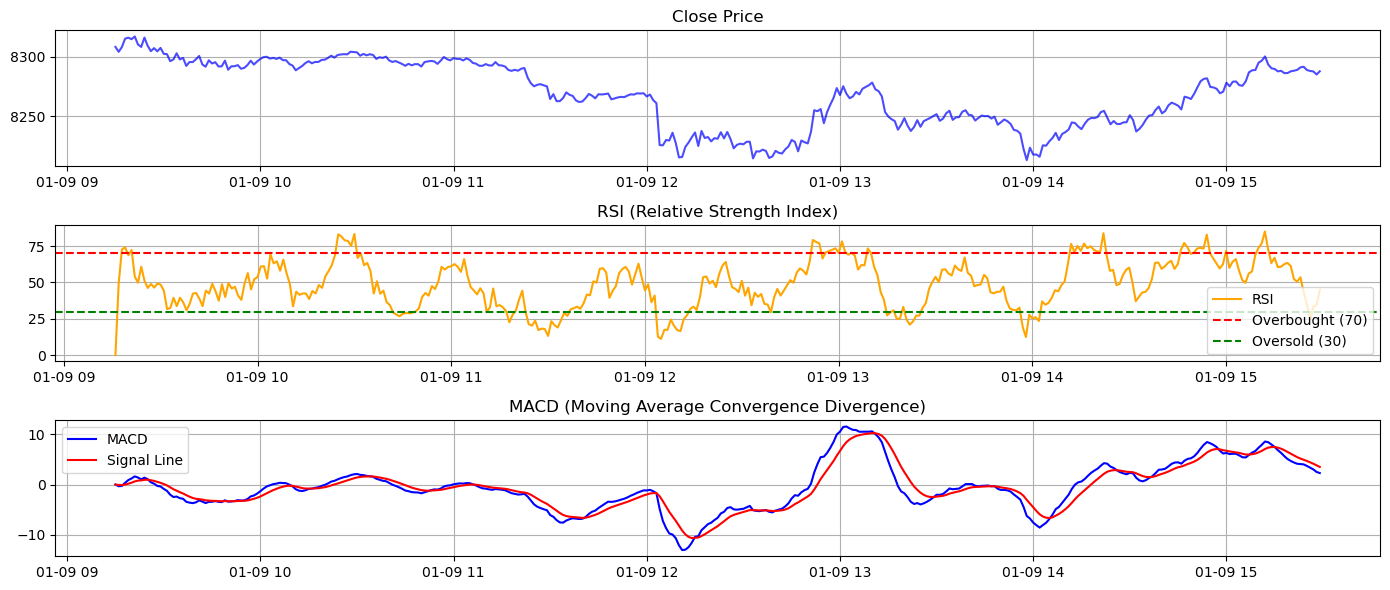

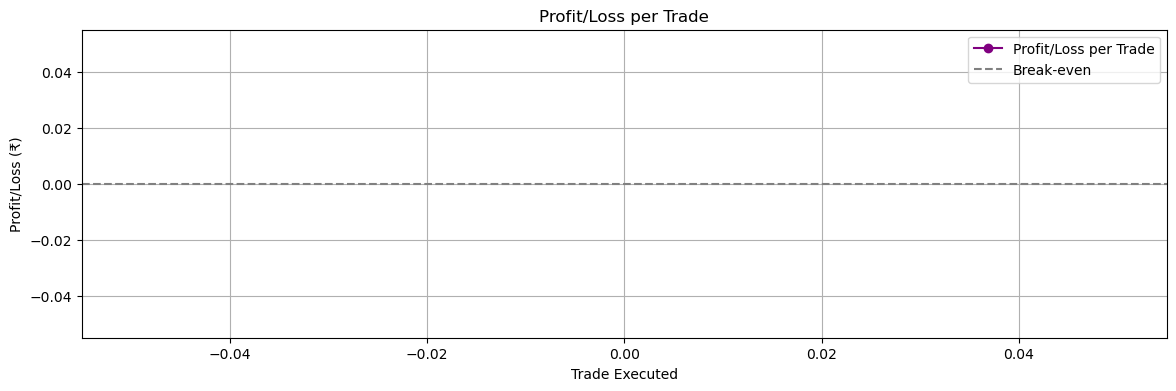

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- RSI Calculation ---
# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI (14-period)
df['RSI'] = calculate_rsi(df['close'], window=14)

# --- MACD Calculation ---
# Calculate MACD and Signal Line
short_ema = df['close'].ewm(span=12, min_periods=1, adjust=False).mean()
long_ema = df['close'].ewm(span=26, min_periods=1, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal_Line'] = df['MACD'].ewm(span=9, min_periods=1, adjust=False).mean()

# --- Generate Buy and Sell Signals ---
# Buy Signal: RSI < 30 and MACD crosses above Signal Line
df['Buy_Signal'] = (df['RSI'] < 30) & (df['MACD'] > df['Signal_Line'])

# Sell Signal: RSI > 70 and MACD crosses below Signal Line
df['Sell_Signal'] = (df['RSI'] > 70) & (df['MACD'] < df['Signal_Line'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, RSI, MACD, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.title('Close Price')
plt.grid(True)

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.legend(loc='best')
plt.grid(True)

# Plot MACD and Signal Line
plt.subplot(3, 1, 3)
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Bollinger Bands Strategy

Initial Balance: ₹10000
Final Balance: ₹9933.61
Total Profit/Loss: ₹-66.39

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 10:40:00    Buy  8296.95   0.000000
1 2015-01-09 12:51:00   Sell  8236.80 -78.177201
2 2015-01-09 13:15:00    Buy  8249.60   0.000000
3 2015-01-09 14:52:00   Sell  8279.40  11.786072


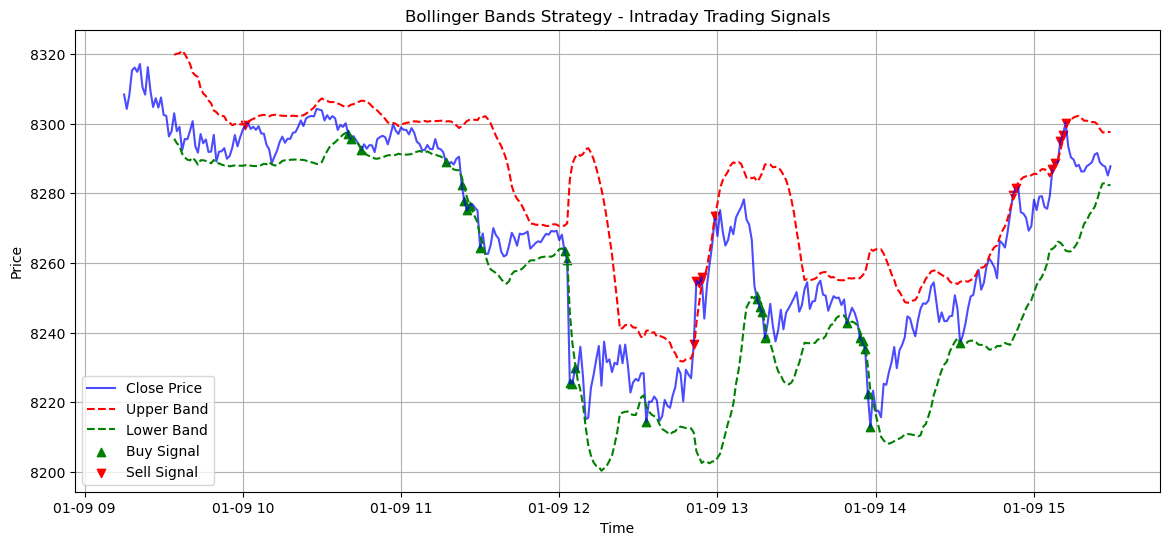

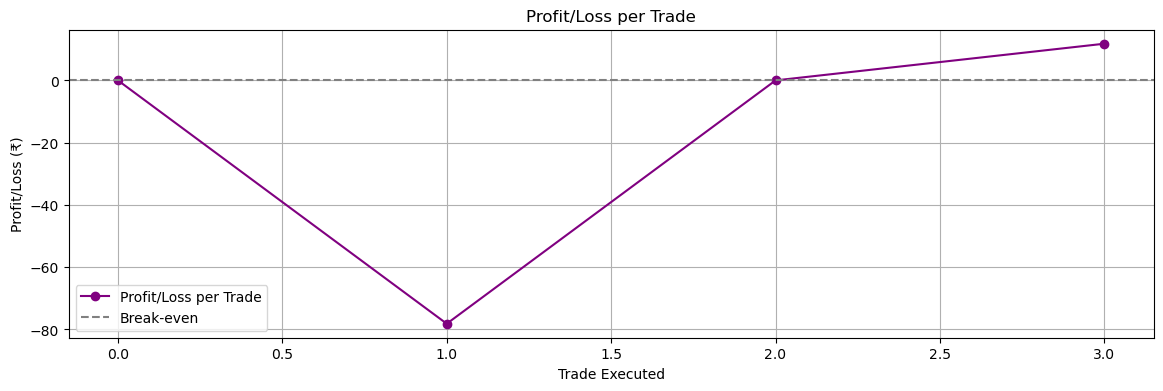

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Bollinger Bands Calculation ---
window = 20  # 20-period moving average
num_std = 2  # Standard deviations for upper and lower bands

# Calculate the moving average and rolling standard deviation
df['SMA'] = df['close'].rolling(window=window).mean()
df['Rolling_STD'] = df['close'].rolling(window=window).std()

# Calculate the upper and lower Bollinger Bands
df['Upper_Band'] = df['SMA'] + (df['Rolling_STD'] * num_std)
df['Lower_Band'] = df['SMA'] - (df['Rolling_STD'] * num_std)

# --- Generate Buy and Sell signals ---
df['Buy_Signal'] = (df['close'] < df['Lower_Band'])  # Buy when price touches or crosses below the lower band
df['Sell_Signal'] = (df['close'] > df['Upper_Band'])  # Sell when price touches or crosses above the upper band

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Bollinger Bands, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle="--", color='red')
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle="--", color='green')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Bollinger Bands Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
CPR (Central Pivot Range) Strategy

Initial Balance: ₹10000
Final Balance: ₹8451.93
Total Profit/Loss: ₹-1548.07

Trade Log:
                   Date Action    Price     Profit
0   2015-01-09 09:17:00    Buy  8308.20   0.000000
1   2015-01-09 09:20:00   Sell  8314.85 -11.468526
2   2015-01-09 09:21:00    Buy  8317.10   0.000000
3   2015-01-09 09:22:00   Sell  8310.40 -24.824578
4   2015-01-09 09:24:00    Buy  8316.20   0.000000
..                  ...    ...      ...        ...
170 2015-01-09 15:09:00    Buy  8288.85   0.000000
171 2015-01-09 15:13:00   Sell  8293.40 -13.524243
172 2015-01-09 15:19:00    Buy  8286.30   0.000000
173 2015-01-09 15:24:00   Sell  8291.55 -12.819384
174 2015-01-09 15:29:00    Buy  8287.75   0.000000

[175 rows x 4 columns]


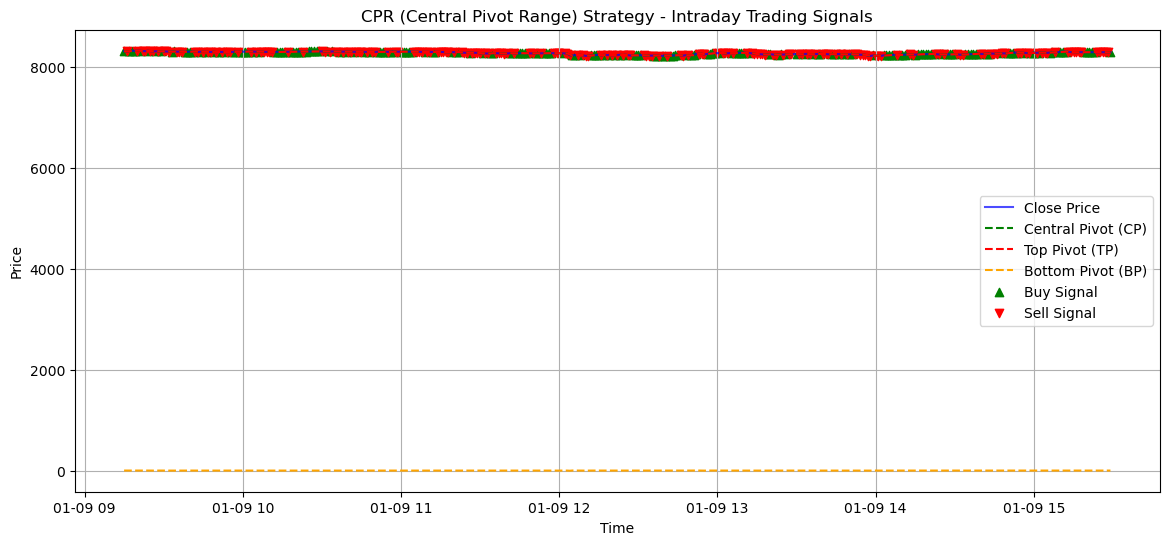

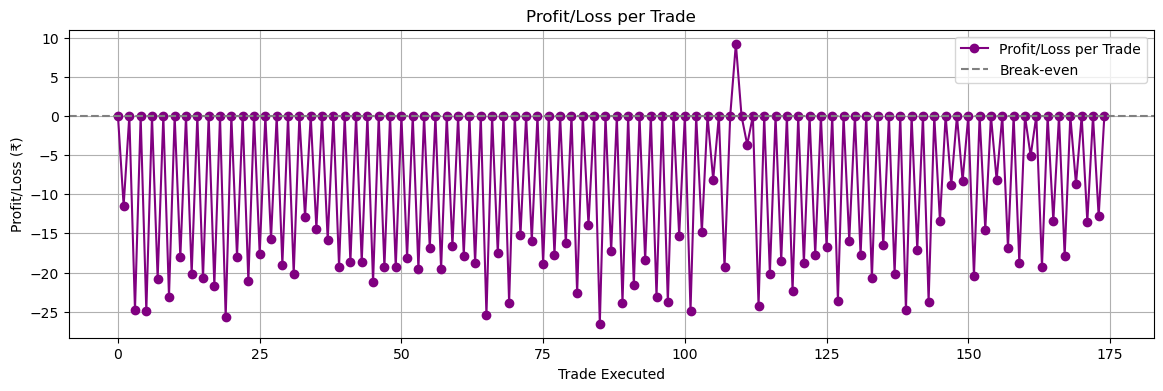

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate CPR (Central Pivot Range) ---
# Calculate the Central Pivot (CP), Top Pivot (TP), and Bottom Pivot (BP) for CPR strategy
df['CP'] = (df['high'] + df['low'] + df['close']) / 3  # Central Pivot
df['TP'] = (df['high'] + df['low']) / 2  # Top Pivot
df['BP'] = (df['CP'] - df['TP']) / 2  # Bottom Pivot

# --- Generate Buy and Sell signals based on CPR ---
df['Buy_Signal'] = df['close'] > df['CP']  # Buy when price is above the CP
df['Sell_Signal'] = df['close'] < df['CP']  # Sell when price is below the CP

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, CPR, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['CP'], label='Central Pivot (CP)', linestyle="--", color='green')
plt.plot(df.index, df['TP'], label='Top Pivot (TP)', linestyle="--", color='red')
plt.plot(df.index, df['BP'], label='Bottom Pivot (BP)', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('CPR (Central Pivot Range) Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
ORB (Opening Range Breakout) Strategy

Opening Range High (ORH): 8317.25
Opening Range Low (ORL): 8300.6
Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


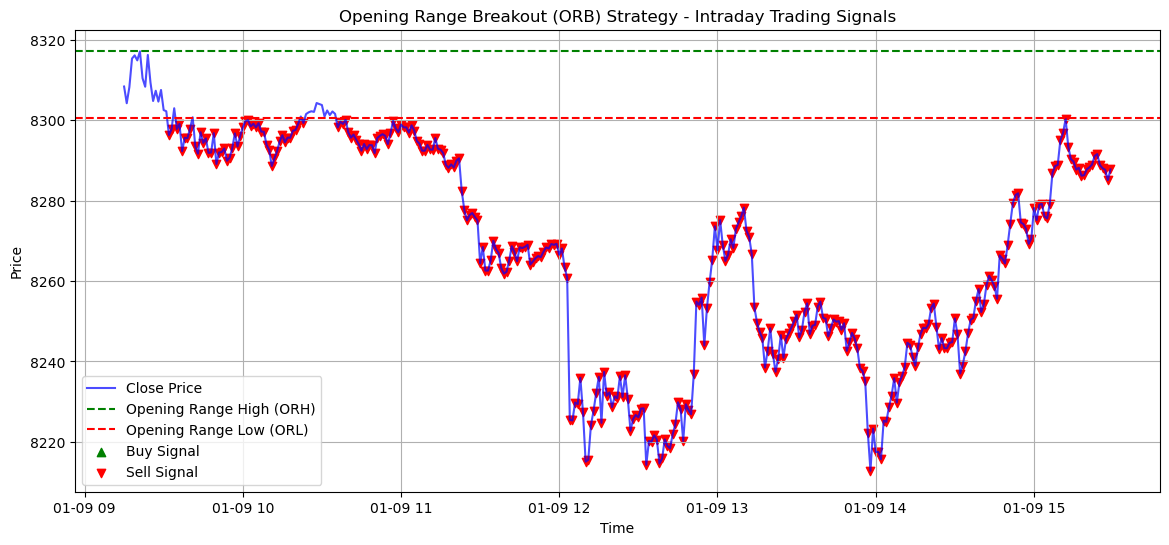

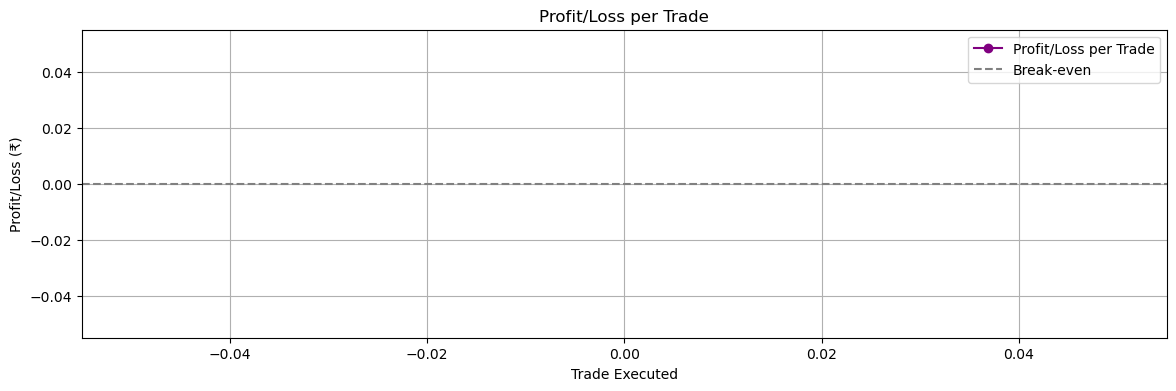

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define the Opening Range ---
# Define the opening range duration (e.g., first 15 minutes)
opening_range_duration = 15  # minutes
start_time = df.index[0]  # Market open time
end_time = start_time + pd.Timedelta(minutes=opening_range_duration)

# Filter the data for the opening range (first 15 minutes)
opening_range_data = df[(df.index >= start_time) & (df.index <= end_time)]

# Calculate the Opening Range High and Low
ORH = opening_range_data['high'].max()  # Highest point in the first 15 minutes
ORL = opening_range_data['low'].min()   # Lowest point in the first 15 minutes

print(f"Opening Range High (ORH): {ORH}")
print(f"Opening Range Low (ORL): {ORL}")

# --- Generate Buy and Sell signals ---
# Buy Signal: Price crosses above ORH
# Sell Signal: Price crosses below ORL

df['Buy_Signal'] = df['close'] > ORH  # Buy when the price is above ORH
df['Sell_Signal'] = df['close'] < ORL  # Sell when the price is below ORL

# --- Track Profits and Losses ---
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Opening Range High and Low
plt.axhline(y=ORH, color='green', linestyle="--", label='Opening Range High (ORH)')
plt.axhline(y=ORL, color='red', linestyle="--", label='Opening Range Low (ORL)')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Opening Range Breakout (ORB) Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Inside Bar Strategy (Price Action-Based)

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


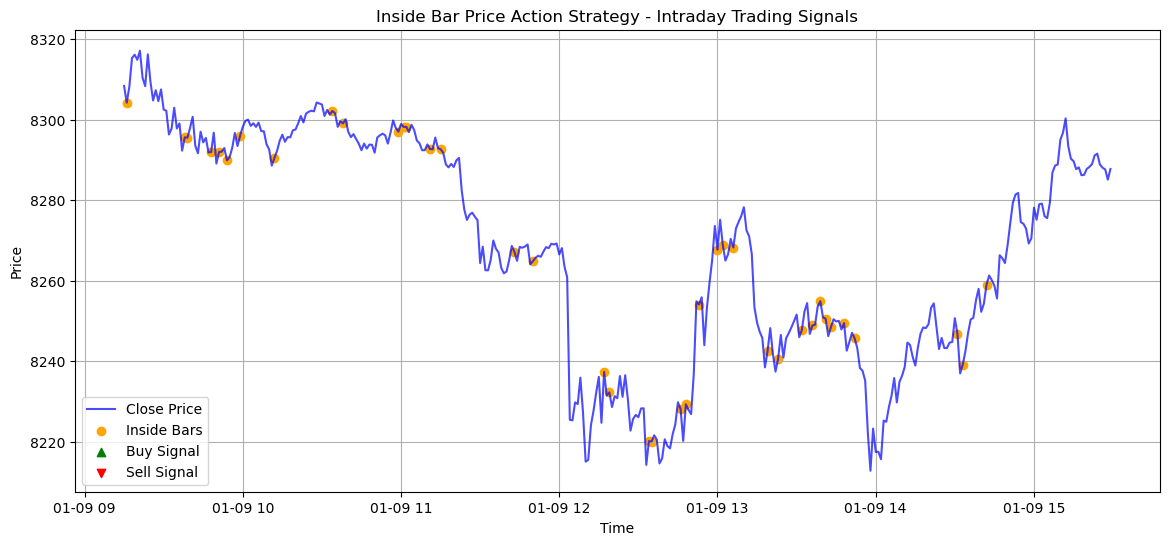

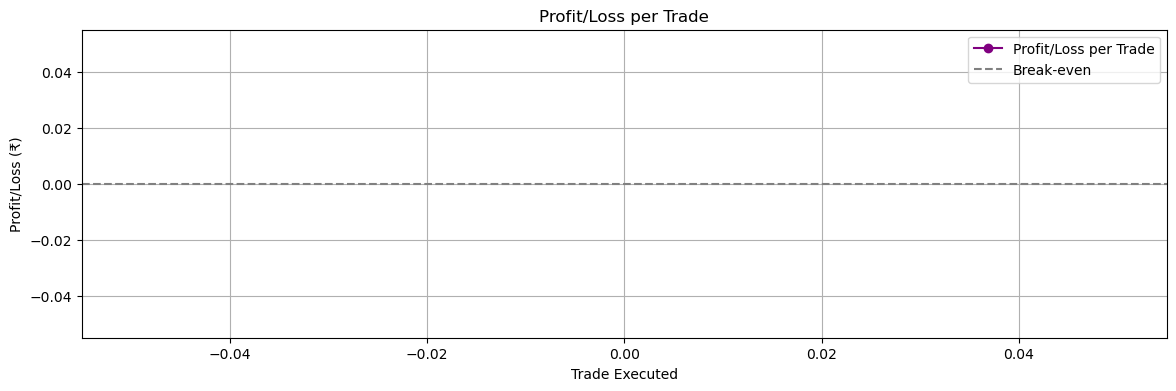

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Detect Inside Bars ---
df['Inside_Bar'] = (df['high'] < df['high'].shift(1)) & (df['low'] > df['low'].shift(1))

# --- Generate Buy and Sell signals ---
# Buy Signal: Price breaks above the high of the inside bar
df['Buy_Signal'] = df['Inside_Bar'] & (df['close'] > df['high'].shift(1))

# Sell Signal: Price breaks below the low of the inside bar
df['Sell_Signal'] = df['Inside_Bar'] & (df['close'] < df['low'].shift(1))

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Highlight Inside Bars
inside_bars = df[df['Inside_Bar']]
plt.scatter(inside_bars.index, inside_bars['close'], marker='o', color='orange', label='Inside Bars', alpha=1)

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Inside Bar Price Action Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Heikin-Ashi Trend Strategy

Initial Balance: ₹10000
Final Balance: ₹8756.60
Total Profit/Loss: ₹-1243.40

Trade Log:
                   Date Action    Price     Profit
0   2015-01-09 09:16:00    Buy  8304.20   0.000000
1   2015-01-09 09:17:00   Sell  8308.20 -14.107156
2   2015-01-09 09:18:00    Buy  8315.30   0.000000
3   2015-01-09 09:20:00   Sell  8314.85 -18.576904
4   2015-01-09 09:21:00    Buy  8317.10   0.000000
..                  ...    ...      ...        ...
129 2015-01-09 15:04:00   Sell  8276.05 -21.145447
130 2015-01-09 15:06:00    Buy  8279.25   0.000000
131 2015-01-09 15:13:00   Sell  8293.40  -3.912915
132 2015-01-09 15:20:00    Buy  8287.75   0.000000
133 2015-01-09 15:25:00   Sell  8288.85 -16.968395

[134 rows x 4 columns]


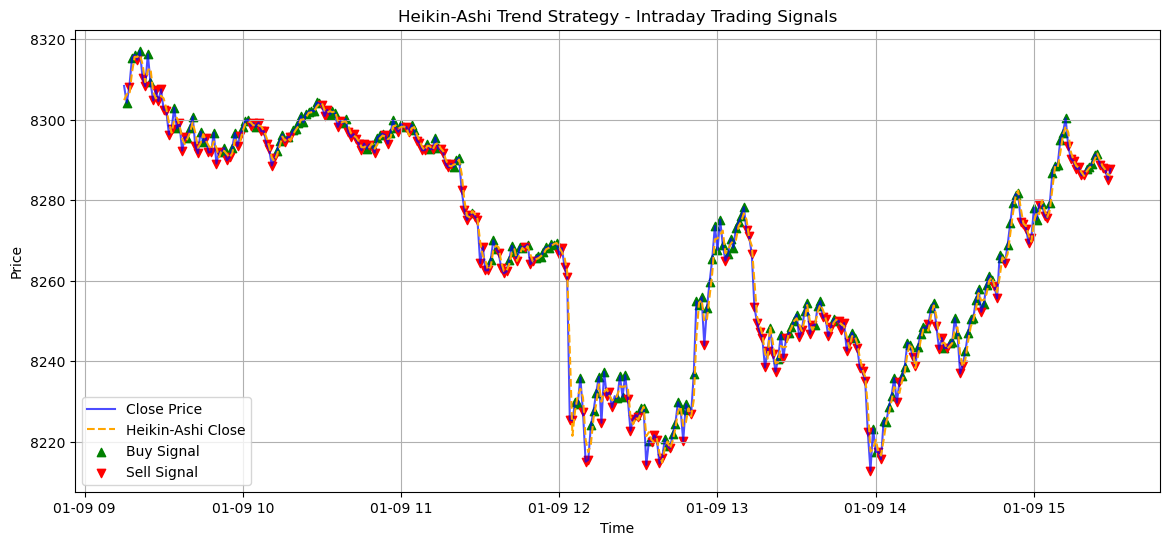

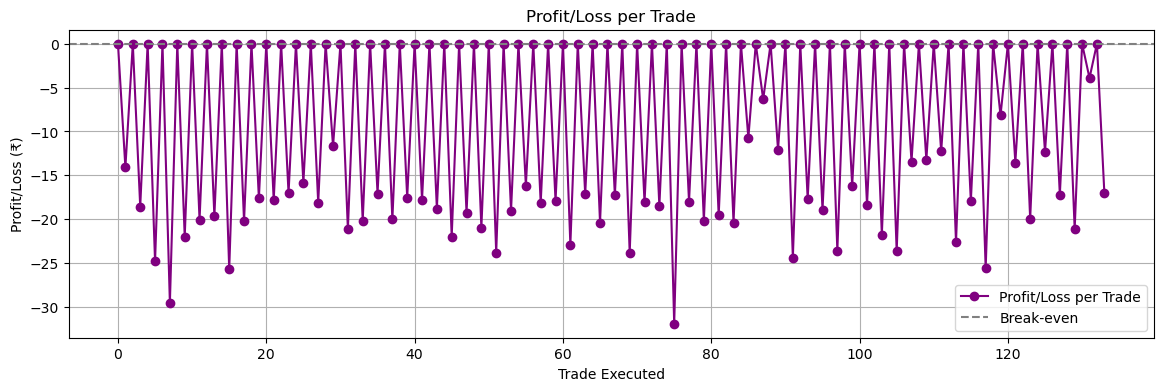

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate Heikin-Ashi Candles ---
df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4  # Heikin-Ashi Close
df['HA_Open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2  # Heikin-Ashi Open (shifted by 1 to get previous open and close)
df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)  # Heikin-Ashi High
df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)  # Heikin-Ashi Low

# --- Generate Buy and Sell signals based on Heikin-Ashi Trend ---
# Buy Signal: Heikin-Ashi candles are bullish (close > open)
df['Buy_Signal'] = (df['HA_Close'] > df['HA_Open'])

# Sell Signal: Heikin-Ashi candles are bearish (close < open)
df['Sell_Signal'] = (df['HA_Close'] < df['HA_Open'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Heikin-Ashi Candles and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Heikin-Ashi candles
plt.plot(df.index, df['HA_Close'], label='Heikin-Ashi Close', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Heikin-Ashi Trend Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Fibonacci Retracement Strategy (Best for Pullbacks)

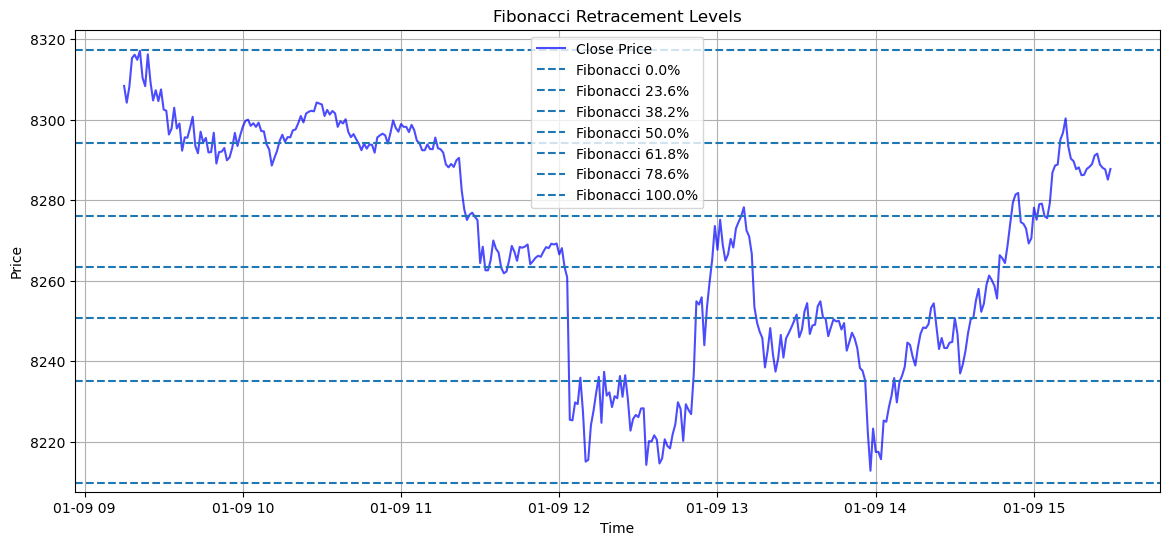

Initial Balance: ₹10000
Final Balance: ₹9947.15
Total Profit/Loss: ₹-52.85

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 11:32:00    Buy  8262.60   0.000000
1 2015-01-09 11:34:00   Sell  8265.15 -15.465018
2 2015-01-09 11:38:00    Buy  8263.20   0.000000
3 2015-01-09 11:41:00   Sell  8265.10 -16.115676
4 2015-01-09 12:02:00    Buy  8263.45   0.000000
5 2015-01-09 12:58:00   Sell  8265.30 -16.166171
6 2015-01-09 13:14:00    Buy  8253.45   0.000000
7 2015-01-09 14:47:00   Sell  8266.35  -5.105421


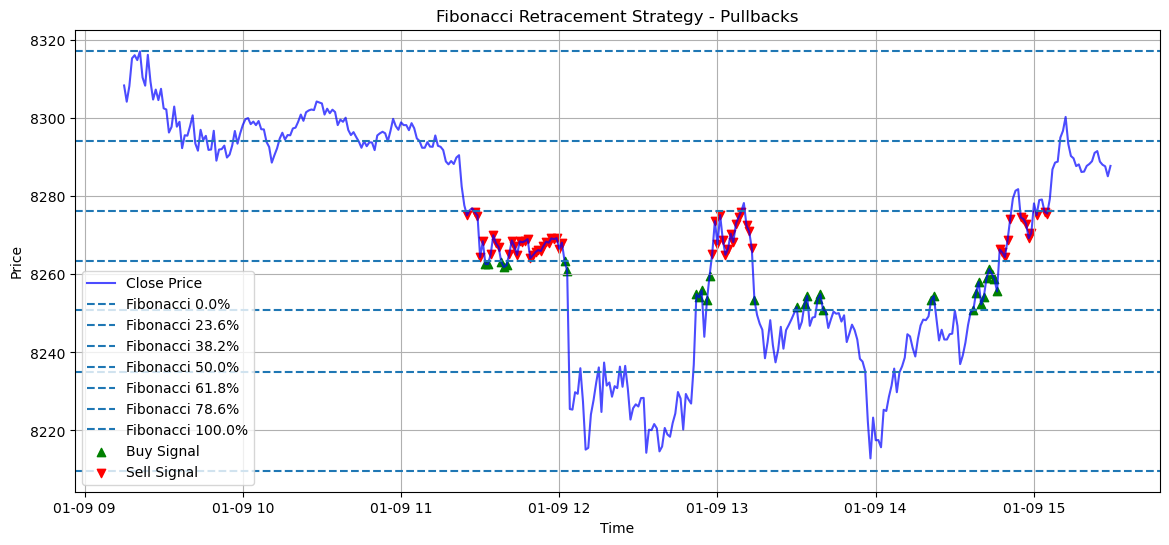

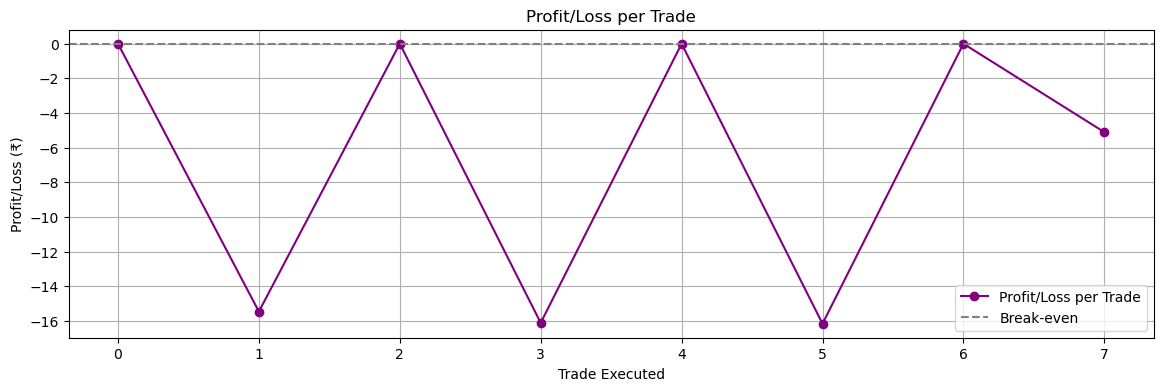

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define Fibonacci Retracement Levels ---
# Let's assume we are in an uptrend and we calculate Fibonacci retracement levels from a significant swing low to swing high.

# Swing low and swing high (adjust based on your timeframe and chart)
swing_low = df['low'].min()  # Adjust if necessary to pick the exact swing low
swing_high = df['high'].max()  # Adjust if necessary to pick the exact swing high

# Fibonacci Retracement Levels
fibonacci_levels = {
    '0.0%': swing_low,
    '23.6%': swing_low + 0.236 * (swing_high - swing_low),
    '38.2%': swing_low + 0.382 * (swing_high - swing_low),
    '50.0%': swing_low + 0.5 * (swing_high - swing_low),
    '61.8%': swing_low + 0.618 * (swing_high - swing_low),
    '78.6%': swing_low + 0.786 * (swing_high - swing_low),
    '100.0%': swing_high
}

# --- Plot Fibonacci Retracement Levels ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Fibonacci levels
for level, price in fibonacci_levels.items():
    plt.axhline(price, label=f'Fibonacci {level}', linestyle="--")

plt.title('Fibonacci Retracement Levels')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Generate Buy and Sell signals based on Fibonacci Retracement ---
# For Buy Signal: Price should be at or near a Fibonacci retracement level and then start to move up
df['Buy_Signal'] = (df['close'] > fibonacci_levels['38.2%']) & (df['close'] < fibonacci_levels['50.0%'])

# For Sell Signal: Price should be at or near a Fibonacci retracement level and then start to move down
df['Sell_Signal'] = (df['close'] > fibonacci_levels['50.0%']) & (df['close'] < fibonacci_levels['61.8%'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Fibonacci levels
for level, price in fibonacci_levels.items():
    plt.axhline(price, label=f'Fibonacci {level}', linestyle="--")

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Fibonacci Retracement Strategy - Pullbacks')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
  Donchian Channel Breakout Strategy

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


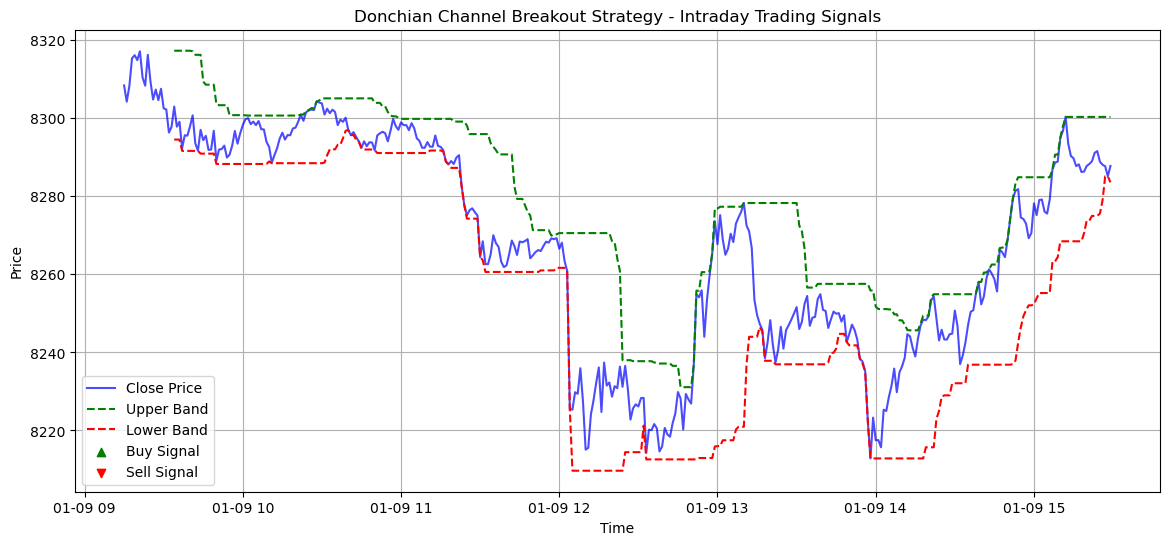

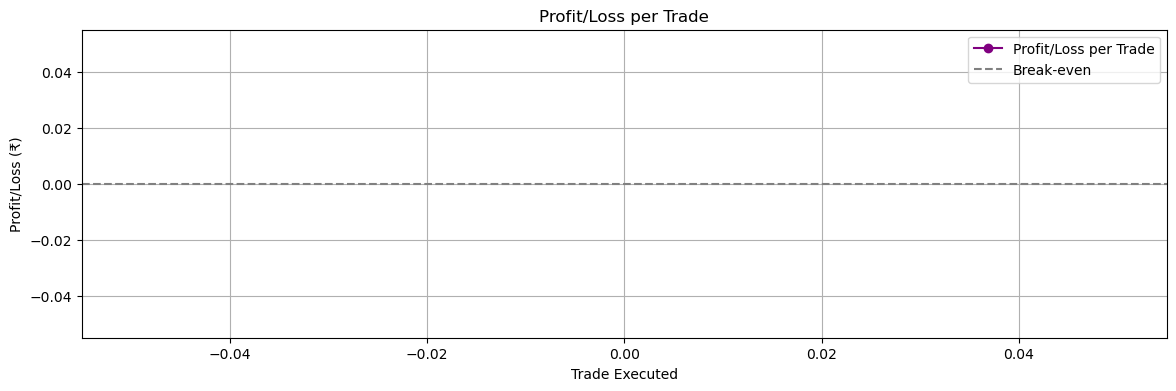

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define Donchian Channel ---
# Define the period for the Donchian Channel (e.g., 20-period)
channel_period = 20

# Calculate the Upper and Lower Bands of the Donchian Channel
df['Upper_Band'] = df['high'].rolling(window=channel_period).max()  # 20-period Upper Band
df['Lower_Band'] = df['low'].rolling(window=channel_period).min()   # 20-period Lower Band

# --- Generate Buy and Sell signals based on Donchian Channel Breakout ---
# Buy Signal: Price crosses above the Upper Band
df['Buy_Signal'] = df['close'] > df['Upper_Band']

# Sell Signal: Price crosses below the Lower Band
df['Sell_Signal'] = df['close'] < df['Lower_Band']

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Donchian Channel, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot the Upper and Lower Bands of the Donchian Channel
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle="--", color='green')
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle="--", color='red')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Donchian Channel Breakout Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
EMA Ribbon Strategy (Exponential Moving Averages)

Initial Balance: ₹10000
Final Balance: ₹9861.53
Total Profit/Loss: ₹-138.47

Trade Log:
                  Date Action    Price     Profit
0  2015-01-09 09:18:00    Buy  8315.30   0.000000
1  2015-01-09 09:28:00   Sell  8304.60 -28.816654
2  2015-01-09 10:03:00    Buy  8298.45   0.000000
3  2015-01-09 10:10:00   Sell  8292.60 -23.934771
4  2015-01-09 10:20:00    Buy  8297.55   0.000000
5  2015-01-09 10:41:00   Sell  8295.65 -19.986759
6  2015-01-09 11:00:00    Buy  8298.90   0.000000
7  2015-01-09 11:07:00   Sell  8294.15 -22.836852
8  2015-01-09 12:51:00    Buy  8236.80   0.000000
9  2015-01-09 13:18:00   Sell  8238.50 -16.257924
10 2015-01-09 13:39:00    Buy  8254.90   0.000000
11 2015-01-09 13:42:00   Sell  8246.25 -26.637032
12 2015-01-09 14:13:00    Buy  8244.10   0.000000


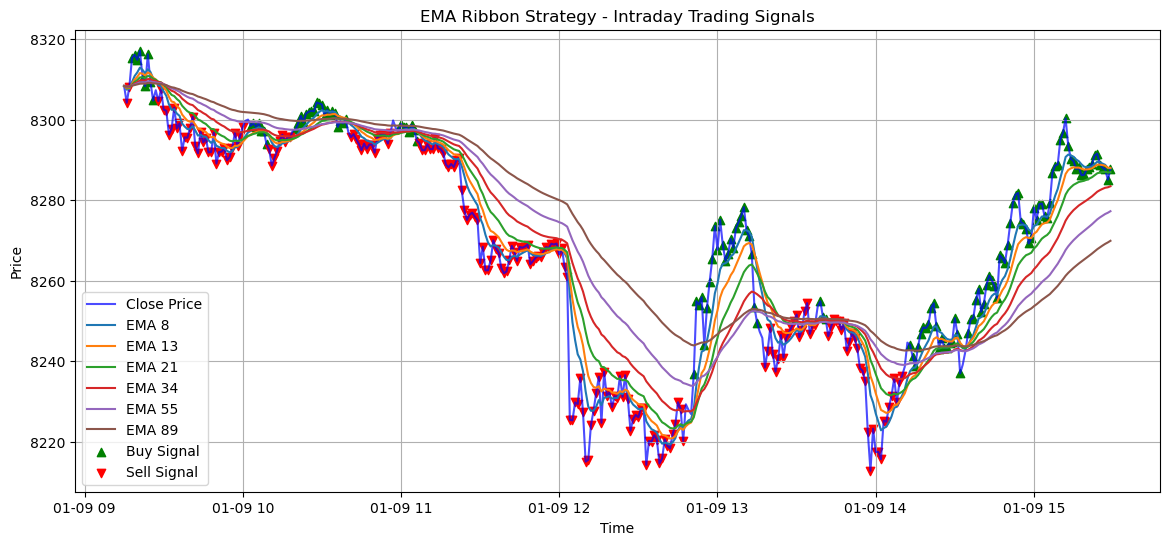

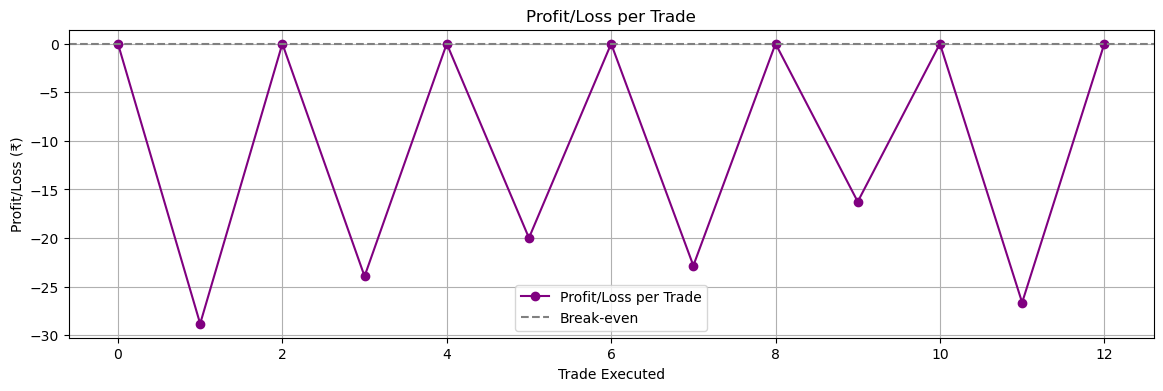

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate Multiple EMAs (for the EMA Ribbon) ---
# Define the periods for the EMAs (e.g., 8, 13, 21, 34, 55, 89)
ema_periods = [8, 13, 21, 34, 55, 89]

# Calculate the EMAs for the specified periods
for period in ema_periods:
    df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

# --- Generate Buy and Sell Signals based on EMA Ribbon ---
# Buy Signal: Short-term EMAs cross above the long-term EMAs (e.g., 8-period EMA crosses above 21-period EMA)
df['Buy_Signal'] = (df['EMA_8'] > df['EMA_21']) & (df['EMA_13'] > df['EMA_21'])

# Sell Signal: Short-term EMAs cross below the long-term EMAs (e.g., 8-period EMA crosses below 21-period EMA)
df['Sell_Signal'] = (df['EMA_8'] < df['EMA_21']) & (df['EMA_13'] < df['EMA_21'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot the EMA Ribbon
for period in ema_periods:
    plt.plot(df.index, df[f'EMA_{period}'], label=f'EMA {period}')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('EMA Ribbon Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
 ATR Trailing Stop Strategy

Initial Balance: ₹10000
Final Balance: ₹10033.10
Total Profit/Loss: ₹33.10


ValueError: x and y must have same first dimension, but have shapes (375,) and (159,)

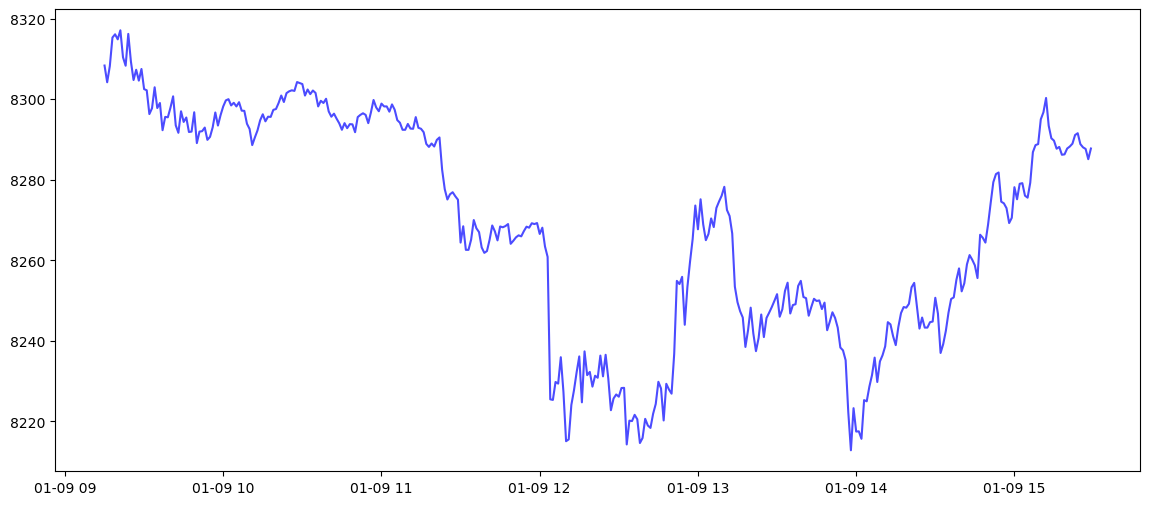

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate ATR (Average True Range) ---
# Calculate True Range (TR) for each period
df['High_Low'] = df['high'] - df['low']
df['High_Close'] = abs(df['high'] - df['close'].shift(1))
df['Low_Close'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculate ATR (Average True Range) over a 14-period window
df['ATR'] = df['TR'].rolling(window=14).mean()

# --- Define the ATR Trailing Stop Strategy ---
# Set the multiple of ATR for the trailing stop
atr_multiple = 2  # You can adjust this value

# Define Buy and Sell Signals (Here, we'll use a simple strategy for demonstration purposes)
# Buy when the price crosses above a simple moving average (SMA) - Example
sma_period = 50  # Simple Moving Average period
df['SMA'] = df['close'].rolling(window=sma_period).mean()

df['Buy_Signal'] = df['close'] > df['SMA']  # Simple Buy signal when the price is above SMA

# --- Implement Trailing Stop Logic ---
# Initialize variables
position = None
entry_price = None
stop_loss = None
balance = 10000  # Starting capital
trade_log = []
stop_loss_list = []

# Simulate the strategy
for i in range(1, len(df)):
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        # Enter Buy position
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        stop_loss = entry_price - (atr_multiple * df['ATR'].iloc[i])  # Set initial stop-loss
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Stop Loss': stop_loss, 'Profit': 0})
        
    elif position == 'Buy':
        # Update stop-loss dynamically (ATR Trailing Stop)
        stop_loss = max(stop_loss, df['close'].iloc[i] - (atr_multiple * df['ATR'].iloc[i]))
        stop_loss_list.append(stop_loss)

        # Sell if price hits stop-loss (Exit signal)
        if df['close'].iloc[i] <= stop_loss:
            sell_price = df['close'].iloc[i]
            profit = sell_price - entry_price
            balance += profit
            trade_log.append({'Date': df.index[i], 'Action': 'Sell', 'Price': sell_price, 'Stop Loss': stop_loss, 'Profit': profit})
            position = None  # Reset position

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - 10000

# Print Results
print(f"Initial Balance: ₹10000")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Pad the stop_loss_list with NaN values to match the length of df.index[1:]
stop_loss_list = stop_loss_list[:len(df.index[1:])]  # Truncate if needed
stop_loss_list = [np.nan] + stop_loss_list  # Add NaN at the beginning to match the length of df.index

# Plot Close Price, Stop Loss, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Stop Loss (Trailing Stop Loss)
plt.plot(df.index, stop_loss_list, label='Trailing Stop Loss', linestyle="--", color='red')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)

plt.legend()
plt.title('ATR Trailing Stop Strategy')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
ADX Trend Strength Strategy

Initial Balance: ₹10000
Final Balance: ₹9893.82
Total Profit/Loss: ₹-106.18

Trade Log:
                  Date Action    Price     Profit
0  2015-01-09 09:57:00    Buy  8296.70   0.000000
1  2015-01-09 10:11:00   Sell  8288.60 -26.178706
2  2015-01-09 10:25:00    Buy  8301.95   0.000000
3  2015-01-09 10:40:00   Sell  8296.95 -23.093251
4  2015-01-09 10:59:00    Buy  8297.00   0.000000
5  2015-01-09 11:08:00   Sell  8292.40 -22.682860
6  2015-01-09 12:52:00    Buy  8254.90   0.000000
7  2015-01-09 13:14:00   Sell  8253.45 -19.444232
8  2015-01-09 13:32:00    Buy  8247.85   0.000000
9  2015-01-09 13:48:00   Sell  8249.50 -16.331963
10 2015-01-09 14:11:00    Buy  8238.65   0.000000
11 2015-01-09 14:27:00   Sell  8243.30 -13.314907
12 2015-01-09 14:38:00    Buy  8255.15   0.000000
13 2015-01-09 15:26:00   Sell  8288.05  14.870873


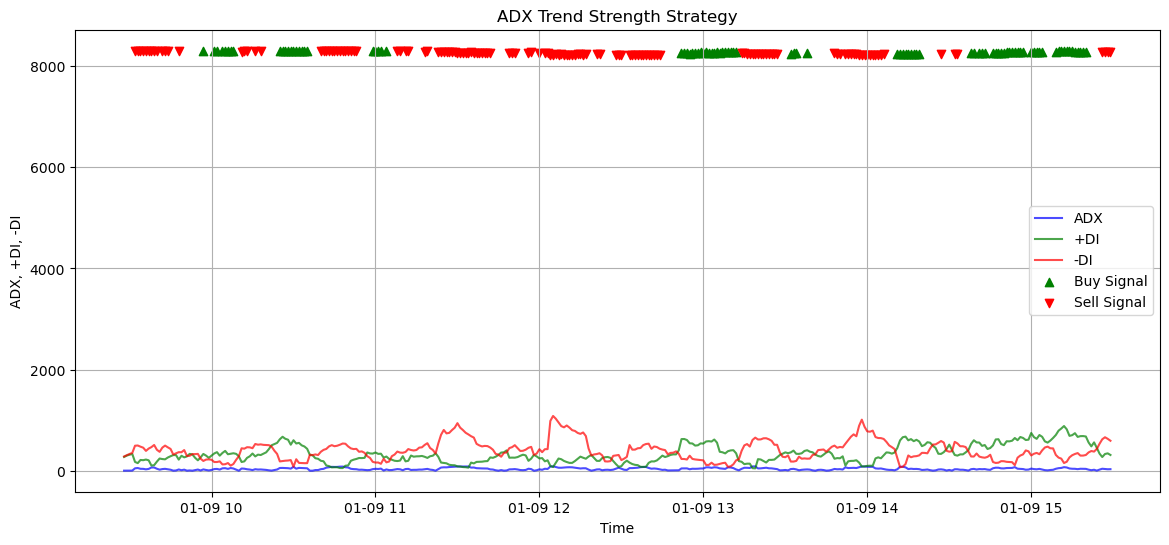

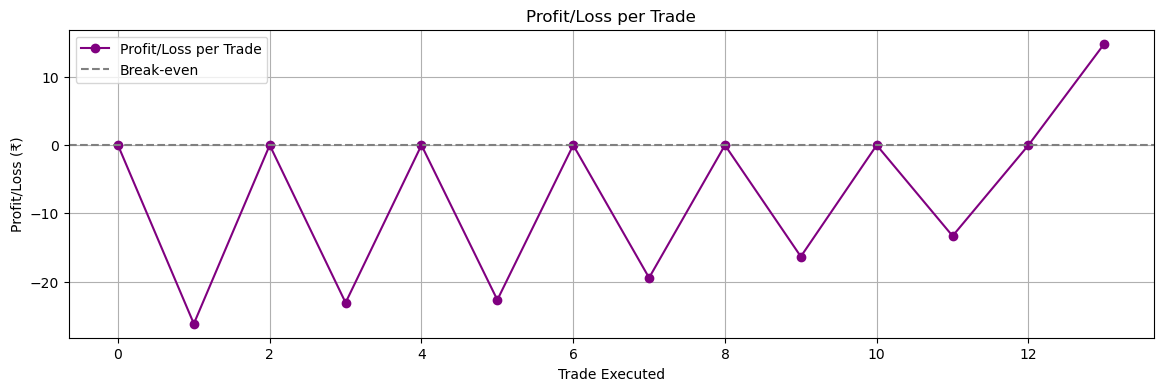

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate ADX, +DI, and -DI ---
# Calculate True Range (TR) for each period
df['High_Low'] = df['high'] - df['low']
df['High_Close'] = abs(df['high'] - df['close'].shift(1))
df['Low_Close'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculate +DM and -DM
df['+DM'] = df['high'] - df['high'].shift(1)
df['-DM'] = df['low'].shift(1) - df['low']

# Apply conditions for +DM and -DM
df['+DM'] = np.where(df['+DM'] > df['-DM'], df['+DM'], 0)
df['-DM'] = np.where(df['-DM'] > df['+DM'], df['-DM'], 0)

# Calculate the smoothed moving averages
df['ATR'] = df['TR'].rolling(window=14).mean()
df['+DI'] = 100 * (df['+DM'].rolling(window=14).sum() / df['ATR'])
df['-DI'] = 100 * (df['-DM'].rolling(window=14).sum() / df['ATR'])

# Calculate ADX (Average Directional Index)
df['ADX'] = 100 * (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']))

# --- Generate Buy and Sell signals based on ADX Strategy ---
# Buy Signal: ADX > 25 and +DI crosses above -DI
df['Buy_Signal'] = (df['ADX'] > 25) & (df['+DI'] > df['-DI'])

# Sell Signal: ADX > 25 and -DI crosses above +DI
df['Sell_Signal'] = (df['ADX'] > 25) & (df['-DI'] > df['+DI'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot ADX, +DI, -DI and Buy/Sell signals
plt.figure(figsize=(14, 6))

# Plot ADX, +DI, and -DI
plt.plot(df.index, df['ADX'], label='ADX', color='blue', alpha=0.7)
plt.plot(df.index, df['+DI'], label='+DI', color='green', alpha=0.7)
plt.plot(df.index, df['-DI'], label='-DI', color='red', alpha=0.7)

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('ADX Trend Strength Strategy')
plt.xlabel('Time')
plt.ylabel('ADX, +DI, -DI')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Parabolic SAR Strategy (Reversal Trading)

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


/var/folders/84/cdsvtxcx62ndqm67dy2d__yr0000gn/T/ipykernel_10203/3113238368.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['SAR'].iloc[0] = df['low'].iloc[0]  # Starting SAR value for the first row
/var/folders/84/cdsvtxcx62ndqm67dy

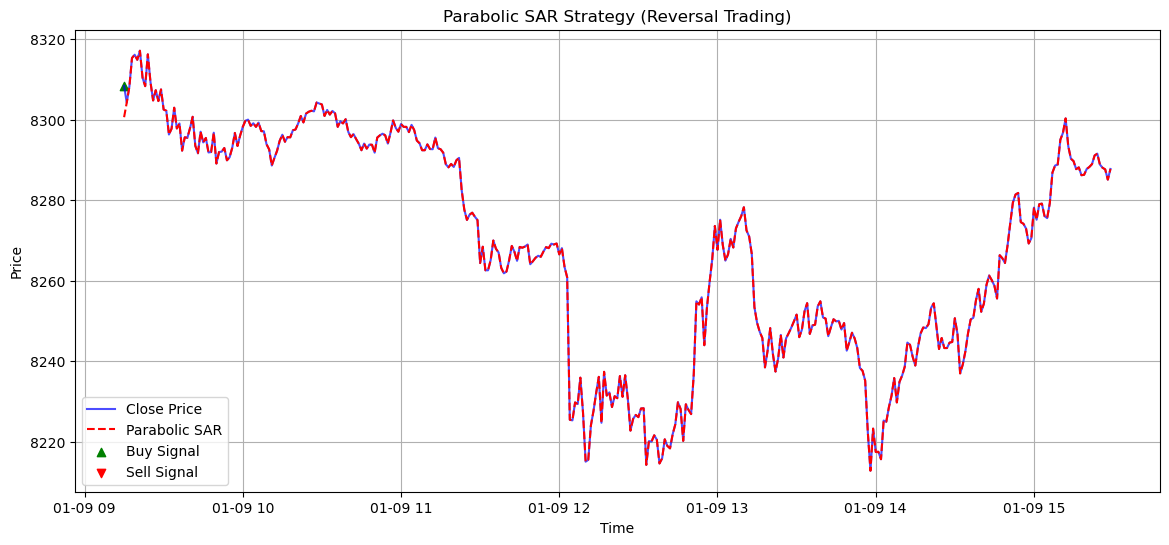

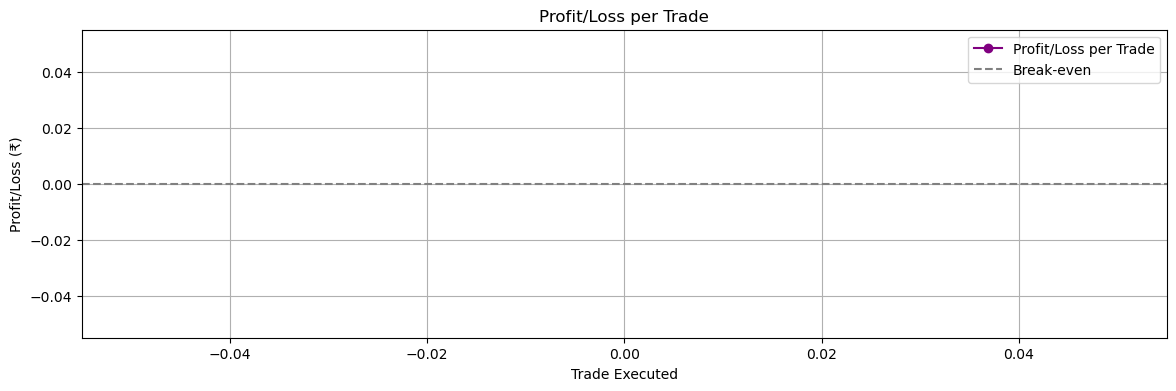

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Parabolic SAR Calculation ---
# Define the parameters for the Parabolic SAR
initial_af = 0.02  # Acceleration Factor
max_af = 0.2  # Maximum Acceleration Factor

# Initialize the columns for the Parabolic SAR, EP, and AF
df['SAR'] = np.nan
df['EP'] = np.nan  # Extreme Point
df['AF'] = initial_af  # Acceleration Factor
df['Trend'] = 1  # 1 for Uptrend, -1 for Downtrend

# Initialize the first values for SAR, EP, and AF
df['SAR'].iloc[0] = df['low'].iloc[0]  # Starting SAR value for the first row
df['EP'].iloc[0] = df['high'].iloc[0]  # Extreme Point is the highest high initially

# Calculate SAR for each row
for i in range(1, len(df)):
    if df['Trend'].iloc[i-1] == 1:  # Uptrend
        df['SAR'].iloc[i] = df['SAR'].iloc[i-1] + df['AF'].iloc[i-1] * (df['EP'].iloc[i-1] - df['SAR'].iloc[i-1])
        # Update the extreme point (EP) if the current high is higher
        df['EP'].iloc[i] = max(df['EP'].iloc[i-1], df['high'].iloc[i])
    else:  # Downtrend
        df['SAR'].iloc[i] = df['SAR'].iloc[i-1] + df['AF'].iloc[i-1] * (df['EP'].iloc[i-1] - df['SAR'].iloc[i-1])
        # Update the extreme point (EP) if the current low is lower
        df['EP'].iloc[i] = min(df['EP'].iloc[i-1], df['low'].iloc[i])

    # Update the Acceleration Factor (AF) if the trend continues
    if df['SAR'].iloc[i] > df['close'].iloc[i]:
        df['SAR'].iloc[i] = df['close'].iloc[i]  # Reversal point
        df['Trend'].iloc[i] = -1  # Change to Downtrend
        df['EP'].iloc[i] = df['low'].iloc[i]  # Update extreme point to the current low
        df['AF'].iloc[i] = initial_af  # Reset AF

    elif df['SAR'].iloc[i] < df['close'].iloc[i]:
        df['SAR'].iloc[i] = df['close'].iloc[i]  # Reversal point
        df['Trend'].iloc[i] = 1  # Change to Uptrend
        df['EP'].iloc[i] = df['high'].iloc[i]  # Update extreme point to the current high
        df['AF'].iloc[i] = initial_af  # Reset AF

    # Update AF (acceleration factor)
    if df['Trend'].iloc[i] == df['Trend'].iloc[i-1]:
        df['AF'].iloc[i] = min(df['AF'].iloc[i-1] + 0.02, max_af)

# --- Generate Buy and Sell signals based on Parabolic SAR ---
# Buy Signal: When SAR is below the price (indicating an uptrend)
df['Buy_Signal'] = df['SAR'] < df['close']  # Buy when SAR is below the price

# Sell Signal: When SAR is above the price (indicating a downtrend)
df['Sell_Signal'] = df['SAR'] > df['close']  # Sell when SAR is above the price

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate
        
        # Total transaction cost
        total_cost = brokerage + gst + stt
        
        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })
        
        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Parabolic SAR, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Parabolic SAR
plt.plot(df.index, df['SAR'], label='Parabolic SAR', linestyle="--", color='red')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Parabolic SAR Strategy (Reversal Trading)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()